## Purpose: create a training set of sources with labels



In [1]:
import splat
import wisps
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
from wisps import datasets

In [3]:
#candidates
candidates=datasets['candidates'].rename(columns={'grism_id':'name'})
#reformating 
candidates[wisps.INDEX_NAMES]=candidates[wisps.INDEX_NAMES].applymap(eval)
candidates=wisps.Annotator.reformat_table(candidates)
#spex
spex=wisps.Annotator.reformat_table(datasets['spex'].rename(columns={'l_snr': 'snr1', 'l_t_snr':'snr2', 'f_x':'f_test'}))
#trash
trash=datasets['all']
trash=wisps.Annotator.reformat_table(trash[~trash.grism_id.isin(candidates.name.values)]).rename(columns={'grism_id':'name'
}) #choose 4 thousands non-brown dwarfs and label them by zero
trash['spt']='none'

In [4]:
spex['spt']=spex.spt.apply(splat.typeToNum)

In [5]:
features=['CH_4/H-Cont', 'CH_4/H_2O-1', 'CH_4/H_2O-2', 'CH_4/J-Cont',
       'H-cont/H_2O-1', 'H-cont/H_2O-2', 'H-cont/J-Cont', 'H_2O-1/J-Cont',
       'H_2O-2/H_2O-1', 'H_2O-2/J-Cont', 'spt', 'spex_chi', 'name', 'snr2', 'line_chi', 'f_test']

In [6]:
man=wisps.Annotator.reformat_table(datasets['manjavacas']).rename(columns={'f':'f_test'})
training_set=pd.concat([candidates[features], spex[features], trash[features], man[features]])
training_set['spt']=training_set.spt.apply(splat.typeToNum)


schn=wisps.Annotator.reformat_table(datasets['schneider']).rename(columns={'f':'f_test'})

In [7]:
training_set=pd.concat( [trash[features], candidates[features], spex[features], man[features], schn[features]])

In [8]:
def add_labels(spt):
    label=0.0
    if np.isnan(spt):
        label=0.0
    if spt<14.0:
        label=0.0
    if 15.1<=spt<20.0:
        label=1.0
    if 20.1<=spt<35.0:
        label=2.0
    if spt>=35.1:
        label=3.0
    return label


In [9]:
training_set['label']=training_set.spt.apply(splat.typeToNum).apply(add_labels)

In [10]:
false_things=training_set[training_set['label']==0.]

In [11]:
#choose only 10% of the true brown dwarf to reflect the ratio of true bds in the set
true_things=training_set[training_set['label']>0.]#.sample(n=int(len(false_things)/1.))

In [12]:
final_training_set=pd.concat([true_things, false_things]).reset_index(drop=True)

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


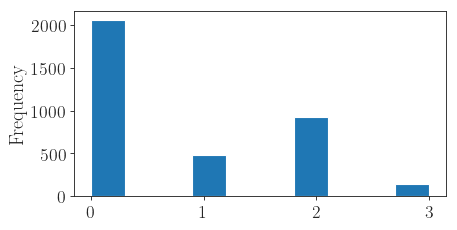

In [13]:
final_training_set.label.plot(kind='hist')

In [14]:
features=['CH_4/H-Cont', 'CH_4/H_2O-1', 'CH_4/H_2O-2', 'CH_4/J-Cont',
       'H-cont/H_2O-1', 'H-cont/H_2O-2', 'H-cont/J-Cont', 'H_2O-1/J-Cont',
       'H_2O-2/H_2O-1', 'H_2O-2/J-Cont',  'spex_chi', 'snr2',
       'line_chi', 'f_test']

final_training_set[features]=final_training_set[features].applymap(float)
final_training_set=final_training_set.replace(np.inf, np.nan).replace(-np.inf, np.nan).replace(np.nan, -999999.9)
final_training_set.to_pickle(wisps.LIBRARIES+'/training_set.pkl')

In [15]:
len(training_set[training_set.label>0])

1553

In [16]:
len(training_set)

3610

In [17]:
len(trash)

1856

In [18]:
len(spex)

1525

In [20]:
len(man)

77

In [21]:
len(schn)

22